In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.compose import ColumnTransformer
# from sklearn.multiclass import OneVsOneClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from datetime import datetime

pd.options.display.max_columns
pd.set_option('display.max_columns', None)

# Data Prep

In [2]:
X_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/X_train.csv', index_col='id')
y_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/y_train.csv', squeeze=True)
X_test = pd.read_csv ('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/X_test.csv')

In [3]:
train_df = X_train
train_df['target'] = y_train
train_df.shape

(3794, 29)

In [4]:
train_df['all_priors'] = train_df[[
    'juv_fel_count',
    'juv_misd_count', 
    'juv_other_count',
    'priors_count'
]].sum(axis=1)


### Drop redundant columns

In [5]:

train_df = train_df.drop([
    'name', 'first', 'last',
    'date_of_birth', 'age',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'priors_count'], axis=1)


### Deal with date dependent features

In [6]:
train_df['c_jail_out'] = pd.to_datetime(train_df.c_jail_out)
train_df['c_jail_in'] = pd.to_datetime(train_df.c_jail_in)

train_df['c_jail_days'] = (train_df.c_jail_out - train_df.c_jail_in)
train_df['c_jail_days'] = train_df['c_jail_days'] // np.timedelta64(1, "D")

# remove rows where c_jail_days is null
# train_df.dropna(subset=["c_jail_days"], inplace=True)
# train_df['c_jail_days'].fillna(0, inplace=True)
# train_df = train_df[train_df['c_jail_days'] >= 0]

# How many days_until_rec
train_df['r_jail_in'] = pd.to_datetime(train_df.r_jail_in)

train_df['days_until_rec'] = (train_df.r_jail_in - train_df.c_jail_out)
train_df['days_until_rec'] = train_df['days_until_rec'] // np.timedelta64(1, "D")


# train_df = train_df[train_df['days_until_rec'] >= 0]

# see if the subject has previously recided
train_df['has_r_jail_in'] = train_df['r_jail_in'].notna()

# check if the are out after receeding
# train_df['has_r_jail_out'] = train_df['r_jail_out'].notna()

# calculate number of days in custody - assumption here is that the time spent in custody could lead to recidivism
train_df['out_custody'] = pd.to_datetime(train_df.out_custody)
train_df['in_custody'] = pd.to_datetime(train_df.in_custody)

train_df['custody_days'] = (train_df.out_custody - train_df.in_custody)
train_df['custody_days'] = train_df['custody_days'] // np.timedelta64(1, "D")

# train_df['custody_days'].fillna(0, inplace=True)

# drop more date columns
train_df = train_df.drop([
    "c_jail_out", "out_custody", "in_custody",
    "c_jail_in", "type_of_assessment", "c_offense_date", 
    "r_jail_out", "r_jail_in",
    "screening_date", "v_screening_date",
    "v_type_of_assessment", "c_arrest_date", 
    'c_charge_desc', 
], axis=1)

# train_df.dropna(subset=["target"], inplace=True)

In [7]:
train_df['target_int'] = train_df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 2})
train_df = train_df.fillna(0)
train_df

,sex,age_group,race,days_b_screening_arrest,c_charge_degree,start,target,all_priors,c_jail_days,days_until_rec,has_r_jail_in,custody_days,target_int
id,,,,,,,,,,,,,
2677,Male,Less than 25,Caucasian,-1.0,F,3,No-Recidivism,2,3.0,0.0,False,4.0,0.0
548,Male,Less than 25,African-American,-1.0,F,0,No-Recidivism,2,-1.0,0.0,False,0.0,0.0
4483,Male,25 - 45,African-American,-1.0,F,3,0,6,4.0,66.0,True,4.0,0.0
9476,Female,25 - 45,African-American,-1.0,F,0,0,3,0.0,0.0,False,1.0,0.0
199,Male,25 - 45,Caucasian,0.0,F,0,No-Recidivism,2,0.0,0.0,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7351,Male,25 - 45,Hispanic,0.0,F,65,0,0,64.0,0.0,False,65.0,0.0
364,Male,25 - 45,African-American,0.0,F,0,No-Recidivism,0,0.0,0.0,False,0.0,0.0
1054,Male,Less than 25,African-American,-306.0,F,0,Violent,3,293.0,0.0,False,294.0,2.0


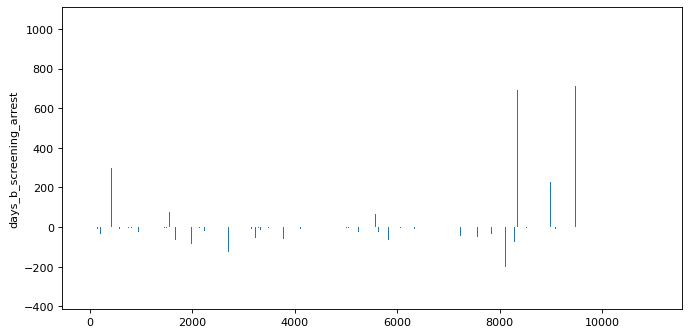

In [8]:
training_features = [
    'sex',
    'age_group',
    'race', 
    'days_b_screening_arrest',
    'c_charge_degree',
    'days_until_rec',
    'start', 'all_priors',
    'c_jail_days',
    'has_r_jail_in',
#     'has_r_jail_out',
    'custody_days'
]

cat_features = [
    'sex', 
    "age_group",
    'race',
    'c_charge_degree',
    'has_r_jail_in',
#     'has_r_jail_out'
]

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 5), dpi=80)

plt.bar(train_df.index, train_df.days_b_screening_arrest)
plt.ylabel('days_b_screening_arrest')
plt.show()


# Model

In [9]:
from catboost import Pool, CatBoostClassifier

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

X_split = train_df
y_split = train_df.race
epoch = 0

TARGET_COL = 'target'

races = train_df.race.unique()
rocs = []
race_rocs = {}
sex_rocs = {}
age_rocs = {}

for train_idx, val_idx in rskf.split(X_split, y_split):

    X_train = X_split.iloc[train_idx].reset_index(drop=True)
    X_val = X_split.iloc[val_idx].reset_index(drop=True)
    
    training_set = Pool(data=X_train[training_features],
                         label=X_train[TARGET_COL],
                         cat_features=cat_features)

    validation_set = Pool(data=X_val[training_features],
                        label=X_val[TARGET_COL],
                        cat_features=cat_features)
    
#     training_set = X_train[training_features]
#     training_target = X_train.target_int

#     validation_set = X_val[training_features]
#     validation_target = X_val.target_int
#     race_validation_set = validation_set[validation_set["race"] == races[0]]
    
#     encode validation_target
#     label_encoder = LabelEncoder()
#     label_encoder.fit(validation_target)
#     validation_target = label_encoder.transform(validation_target)

#     # encode dataset
#     encoder = ColumnTransformer(
#         [("OneHotEncoder", OneHotEncoder(), cat_features)],
#         remainder='passthrough'
#     ).fit(training_set)
    
#     training_set = encoder.transform(training_set)
#     validation_set = encoder.transform(validation_set)

# #     normalize dataset
#     normalizer = Normalizer().fit(training_set)
    
#     training_set = normalizer.transform(training_set)
#     validation_set = normalizer.transform(validation_set)

# #     fit model
#     model = LogisticRegressionCV(cv=6, random_state=0, max_iter=10000)
#     model.fit(training_set, training_target)

# #     prediction
#     prediction = model.predict(validation_set)
#     prediction_proba = model.predict_proba(validation_set)
#     score = model.score(training_set, training_target)
#     roc = roc_auc_score(validation_target, prediction_proba, multi_class="ovo")
#     rocs.append(roc)
    
    y_eval = pd.get_dummies(X_val[TARGET_COL]).to_numpy()
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=3,
                               loss_function='MultiClass')
    
    # Fit model
    model.fit(training_set, verbose=False)
#     # Get predicted probabilities for each class
    preds_proba = model.predict_proba(validation_set)
    
    roc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    
#   subset of validation_set
#     for race in races:
        
#         try:
#             race_validation_target = validation_target[race_validation_set.index]
#             race_prediction_proba = prediction_proba[race_validation_set.index]
#             race_roc = roc_auc_score(race_validation_target, race_prediction_proba, multi_class="ovo")
#             race_rocs[race] = race_roc
#         except:
#             pass
    
    

    epoch += 1
#     print(f"epoch: {epoch} - score: {score:.4f} - roc: {roc:.4f}")
    print(f"epoch: {epoch} - roc: {roc:.4f}")


# print(f"race_roc = {race_rocs})

epoch: 1 - roc: 0.4911


TypeError: No matching signature found

In [ ]:
import pickle

pkl_filename = 'logistic_reg_cv.pkl'
logistic_reg_cv_model_pkl = open(pkl_filename, 'wb')
pickle.dump(model, logistic_reg_cv_model_pkl)

logistic_reg_cv_model_pkl.close()

In [ ]:
test_df = X_test[training_features]